In [2]:
# modules

import numpy as np
import matplotlib.pyplot as plt
from math import floor as flr
from matplotlib.animation import FuncAnimation

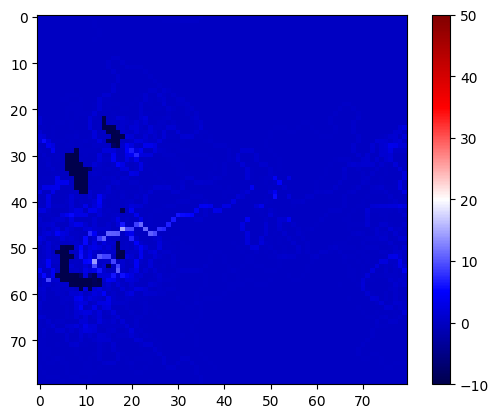

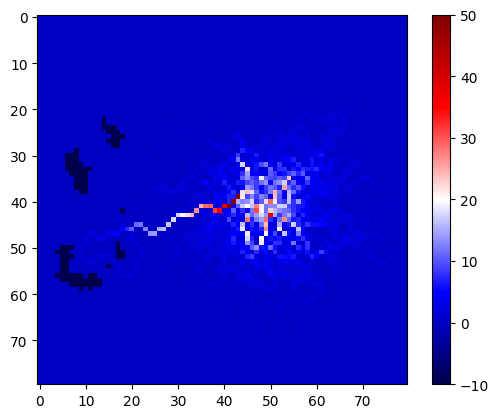

In [132]:
# maps

N_r = 80
N_c = 80

pher_food = np.zeros([N_r, N_c])
pher_home = np.zeros([N_r, N_c])
food_map = np.zeros([N_r, N_c])
home_map = np.zeros([N_r, N_c])

moves = [[1,0], [1,1], [0,1], [-1,1], [-1,0], [-1,-1], [0,-1], [1,-1]]

# ant class

def p(i):
    return (2 + i)**3
p = np.vectorize(p)

class ant:
    def __init__(self, row, col, desire, in_travel, direction):
        self.row = row
        self.col = col
        self.desire = desire
        self.travel = in_travel
        self.dir = direction

    def aging(self):
        self.travel += 1
        if self.travel > 80:
            r = np.random.rand()
            if r < 0.02:
                self.row = np.random.choice(a = np.array(range(35,45)))
                self.col = np.random.choice(a = np.array(range(45,55)))
                self.dir = np.random.choice(9)
                self.travel = 0

    def found_food(self):
        self.dir = (self.dir + 4) % 8
        self.desire = "home"
        self.travel = 0

    def reached_home(self):
        self.dir = (self.dir + 4) % 8
        self.desire = "food"
        self.travel = 0

    def move(self):

        # leave pheromones

        if self.desire == "home":
            pher_food[self.row, self.col] += 5*2**(-self.travel/10)
        if self.desire == "food":
            pher_home[self.row, self.col] += 5*2**(-self.travel/10)

        # find if you have food in front of you

        if self.desire == "food":
            for i in [-1, 0, 1]:
                if food_map[(self.row + moves[flr((self.dir+i)%8)][0])%N_r, (self.col + moves[flr((self.dir+i)%8)][1])%N_c] > 0:

                    # if you do, take it
                    food_map[(self.row + moves[flr((self.dir+i)%8)][0])%N_r, (self.col + moves[flr((self.dir+i)%8)][1])%N_c] -= 1
                    
                    # and run
                    self.found_food()
                    
                    break

        # find if you have home in front of you

        if self.desire == "home":
            for i in [-1, 0, 1]:
                if home_map[(self.row + moves[flr((self.dir+i)%8)][0])%N_r, (self.col + moves[flr((self.dir+i)%8)][1])%N_c] > 0:

                    # if you do, go for an adventure
                    self.reached_home()
                    
                    break

        # change (maybe) direction

        # firstly choose three fields in front of you
            
        near = [] 
        for i in [-1, 0, 1]:
            near.append([self.row + moves[flr(self.dir + i) % 8][0], self.col + moves[flr(self.dir + i) % 8][1]])
        
        # check level of pheromones there

        pher = []
        if self.desire == "food":
            for n in near:
                pher.append(pher_food[n[0] % N_r, n[1] % N_c])

        if self.desire == "home":
            for n in near:
                pher.append(pher_home[n[0] % N_r, n[1] % N_r])

        # calculate probability of going there

        probs = p(np.array(pher))
        probs = probs/np.sum(probs)

        # and change direction

        i = np.random.choice(a = [-1,0,1], p = probs)
        self.dir = (self.dir + i) % 8

        # let's go

        self.row += moves[flr(self.dir)][0]
        self.row = self.row % N_r
        self.col += moves[flr(self.dir)][1]
        self.col = self.col % N_r
        
# ant colony

ants_number = 100
colony = []
for a in range(ants_number):
    spawn = []
    spawn.append(np.random.choice(a = np.array(range(35,45))))
    spawn.append(np.random.choice(a = np.array(range(45,55))))
    where = np.random.choice(np.array(range(9)))
    colony.append(ant(spawn[0], spawn[1], "food", 0, where))

# home & food

for i in range(20, 60):
    for c in range(30):
        food_map[i,c] = 2

for i in range(35, 45):
    for c in range(45, 55):
        home_map[i,c] = 1

frames = []

time = 4000

for t in range(time):
    ant_map = np.zeros([N_r, N_c])
    for ant in colony:
        ant_map[ant.row, ant.col] += 1
        ant.move()
        ant.aging()

    pher_food *= 0.99
    pher_home *= 0.99

    if t % 2 == 0:
        frames.append([pher_home - 10*food_map, pher_food -10*food_map])

plt.imshow(pher_food -10*food_map, cmap = "seismic", vmin = -10, vmax = 50)
plt.colorbar()
plt.show()
plt.imshow(pher_home -10*food_map, cmap = "seismic", vmin = -10, vmax = 50)
plt.colorbar()
plt.show()

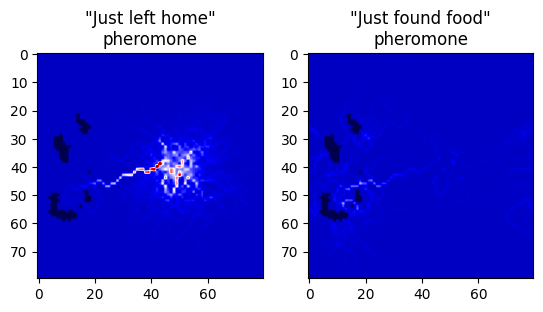

In [134]:
# create animation

# create a figure with two subplots

fig, (ax1, ax2) = plt.subplots(1,2)

# intialize two line objects (one in each axes)

im1 = ax1.imshow(np.empty([N_r, N_c]), cmap = "seismic", animated = True, vmin = -10, vmax = 50)
im2 = ax2.imshow(np.empty([N_r, N_c]), cmap = "seismic", animated = True, vmin = -10, vmax = 50)
ax1.set_title("\"Just left home\"\npheromone")
ax2.set_title("\"Just found food\"\npheromone")
im = [im1, im2]

# initialize the data arrays 

def animate(i):

    # update the data of both line objects
    im[0].set_data(frames[i][0])
    im[1].set_data(frames[i][1])

    return im

from matplotlib.animation import FFMpegWriter as Writer

animation = FuncAnimation(fig, animate, 2000, blit=True, interval=100)
writer = Writer(fps=50, metadata=dict(artist='Me'), bitrate=1800)
animation.save("Lab9/Chemtrails.mp4", writer = writer, dpi = 200)